# ECE180 HW2

## Name: Bharat Kathi

# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs) with your assignment submission.

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [125]:
# Run some setup code for this notebook.

from builtins import range
from builtins import object
import random
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [126]:
from keras.datasets import cifar10
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.squeeze()
y_test = y_test.squeeze()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


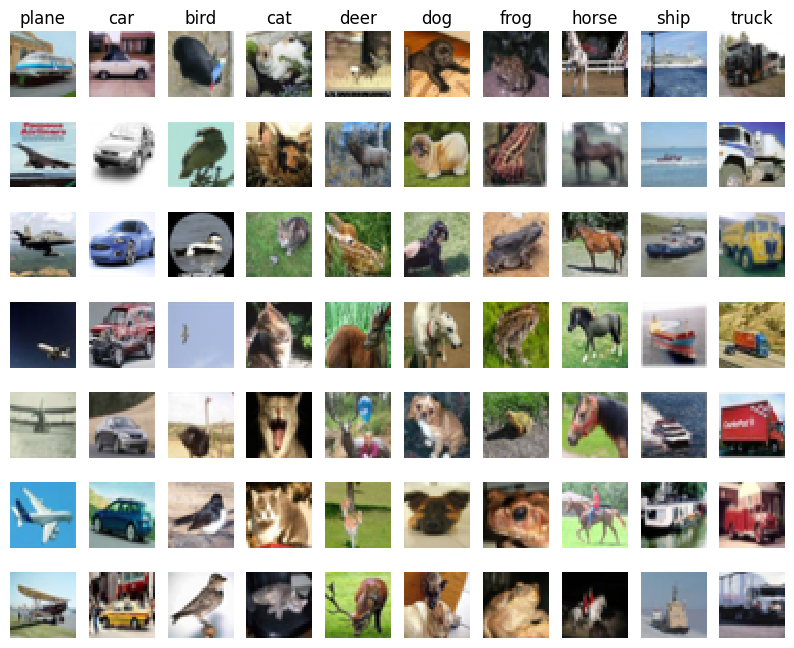

In [127]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [128]:
# Subsample the data for more efficient code execution in this exercise
# Take 5,000 samples from training set and 500 samples from test set.

num_training = 5000
num_test = 500

#####################################################################
# TODO:                                                             #
# Randomly select 5000 and 500 samples from train and test set.     #
# Overwrite them to X_train, y_train, X_test, y_test.               #
# Use the above visualization to double-check images and labels.    #
#####################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

indices_train = np.random.choice(X_train.shape[0], num_training, replace=False)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

indices_test = np.random.choice(X_test.shape[0], num_test, replace=False)
X_test = X_test[indices_test]
y_test = y_test[indices_test]

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

In [129]:
# Reshape the image data into rows
# Output should be (5000, 3072) (500, 3072)
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [130]:
class KNearestNeighbor(object):
    """ a kNN classifier """

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
          consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
             y[i] is the label for X[i].
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X, k=1):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
             of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    def compute_distances(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        #####################################################################
        # TODO:                                                             #
        # Compute the l2 distance between the ith test point and the jth    #
        # training point, and store the result in dists[i, j]. You should   #
        # not use a loop over dimension, nor use np.linalg.norm().          #
        # Try to use numpy function to compute dists by a single function   #
        # call, comparing a matrix and a matrix. (deduction 0)              #
        # You can iterate for test samples to compute distances between a   #
        # vector (a test sample) and a matrix (train samples). (deduction 2)#
        # Or you can have two iterations (two for) to compute distances     #
        # between a vector (a test sample) and a vector (a train sample),   #
        # but that will be slow and your cross-validation will take a long  #
        # time.                                                             #
        #####################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # for i in range(num_test):
        #   dists[i] = np.sqrt(np.sum(np.square(X[i] - self.X_train), axis = 1))

        test_square = np.sum(X**2, axis=1, keepdims=True)
        train_square = np.sum(self.X_train**2, axis=1, keepdims=True).T
        dists = np.sqrt(test_square + train_square - 2 * np.dot(X, self.X_train.T))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return dists


    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test, dtype=int)  # Ensure dtype is int for indexing
        for i in range(num_test):
            # A list of length k storing the labels of the k nearest neighbors to
            # the ith test point.
            #########################################################################
            # TODO:                                                                 #
            # Use the distance matrix to find the k nearest neighbors of the ith    #
            # testing point, and use self.y_train to find the labels of these       #
            # neighbors. Store these labels in closest_y.                           #
            # Hint: Look up the function numpy.argsort.                             #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            closest_y_indices = np.argsort(dists[i])[:k]
            closest_y = self.y_train[closest_y_indices]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            #########################################################################
            # TODO:                                                                 #
            # Now that you have found the labels of the k nearest neighbors, you    #
            # need to find the most common label in the list closest_y of labels.   #
            # Store this label in y_pred[i]. Break ties by choosing the smaller     #
            # label.                                                                #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            # Voting mechanism: Find the most frequent label

            unique, counts = np.unique(closest_y, return_counts=True)
            y_pred[i] = unique[np.argmax(counts)]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        return y_pred

In [131]:
# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [132]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
dists = classifier.compute_distances(X_test)
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 52 / 500 correct => accuracy: 0.104000


You should expect to see approximately `20%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [133]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 52 / 500 correct => accuracy: 0.104000


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [147]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100] #You can reduce the k's if the running time is too long.
# k_choices = [1, 3, 5, 8, 10, 12]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for curr_k in k_choices:
    k_to_accuracies[curr_k] = []
    for curr_fold in range(num_folds):
        classifier = KNearestNeighbor()
        classifier.train(np.concatenate(X_train_folds[:curr_fold] + X_train_folds[curr_fold + 1:]), np.concatenate(y_train_folds[:curr_fold] + y_train_folds[curr_fold + 1:]))
        y_pred_fold = classifier.predict(X_train_folds[curr_fold], k = curr_k)
        k_to_accuracies[curr_k].append(np.mean(y_pred_fold == y_train_folds[curr_fold]))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.167857
k = 1, accuracy = 0.169082
k = 1, accuracy = 0.174796
k = 1, accuracy = 0.180102
k = 1, accuracy = 0.171020
k = 3, accuracy = 0.151429
k = 3, accuracy = 0.149592
k = 3, accuracy = 0.153878
k = 3, accuracy = 0.161837
k = 3, accuracy = 0.152551
k = 5, accuracy = 0.154694
k = 5, accuracy = 0.153571
k = 5, accuracy = 0.155408
k = 5, accuracy = 0.163061
k = 5, accuracy = 0.156837
k = 8, accuracy = 0.150408
k = 8, accuracy = 0.154082
k = 8, accuracy = 0.157653
k = 8, accuracy = 0.163673
k = 8, accuracy = 0.153367
k = 10, accuracy = 0.151531
k = 10, accuracy = 0.152449
k = 10, accuracy = 0.156735
k = 10, accuracy = 0.162449
k = 10, accuracy = 0.149184
k = 12, accuracy = 0.153163
k = 12, accuracy = 0.151735
k = 12, accuracy = 0.155510
k = 12, accuracy = 0.161429
k = 12, accuracy = 0.150000
k = 15, accuracy = 0.152041
k = 15, accuracy = 0.153469
k = 15, accuracy = 0.153980
k = 15, accuracy = 0.160000
k = 15, accuracy = 0.152449
k = 20, accuracy = 0.149898
k = 20, accu

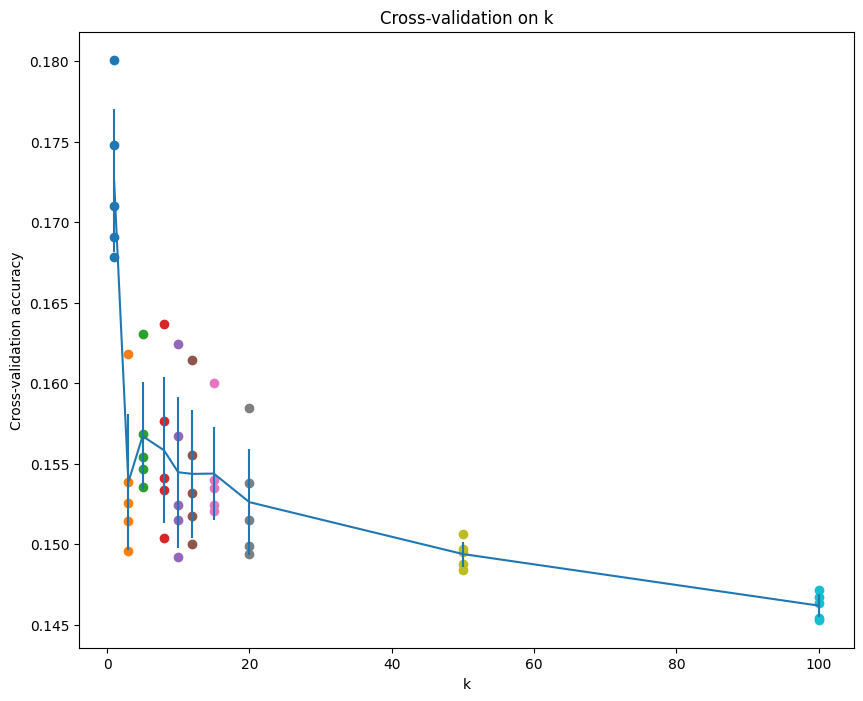

In [148]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [149]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = k_choices[accuracies_mean.argmax()]

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 184 / 500 correct => accuracy: 0.368000


# Softmax exercise


This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [137]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    y_train = y_train.squeeze()
    y_test = y_test.squeeze()

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image_original = np.mean(X_train, axis = 0)
    mean_image = mean_image_original.astype(np.uint8)

    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Clear previously loaded data.
Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier



In [138]:
def softmax_loss(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    num_classes = W.shape[1]
    num_train = X.shape[0]

    scores = X.dot(W)
    scores -= scores.max(axis = 1, keepdims = True)

    probs = np.exp(scores)/np.sum(np.exp(scores), axis = 1, keepdims = True)

    loss = -np.log(probs[np.arange(num_train), y])
    loss = np.sum(loss)

    dscores = probs.reshape(num_train, -1)
    dscores[np.arange(num_train), y] -= 1

    dW = np.dot(X.T.reshape(X.shape[1], num_train), dscores)
    loss /= num_train
    dW /= num_train
    loss += reg * np.sum(W * W)
    dW += 2 * reg * W

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

In [139]:
class Softmax(object):
    def __init__(self):
        self.W = None

    def train(
        self,
        X,
        y,
        learning_rate=1e-3,
        reg=1e-5,
        num_iters=100,
        batch_size=200,
        verbose=False,
    ):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (
            np.max(y) + 1
        )  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            indices = np.random.choice(num_train, batch_size)
            X_batch = X[indices]
            y_batch = y[indices]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        y_pred = np.argmax(X.dot(self.W), axis = 1)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return softmax_loss(self.W, X_batch, y_batch, reg)

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [140]:
# In the file linear_classifier.py, implement SGD in the function
softmax = Softmax()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)

iteration 0 / 1500: loss 786.942138
iteration 100 / 1500: loss 286.234105
iteration 200 / 1500: loss 105.929184
iteration 300 / 1500: loss 39.916208
iteration 400 / 1500: loss 15.924812
iteration 500 / 1500: loss 7.193934
iteration 600 / 1500: loss 4.006732
iteration 700 / 1500: loss 2.870526
iteration 800 / 1500: loss 2.436226
iteration 900 / 1500: loss 2.241114
iteration 1000 / 1500: loss 2.256278
iteration 1100 / 1500: loss 2.194643
iteration 1200 / 1500: loss 2.153940
iteration 1300 / 1500: loss 2.191554
iteration 1400 / 1500: loss 2.224378


In [141]:
# Write the Softmax.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.256612
validation accuracy: 0.266000


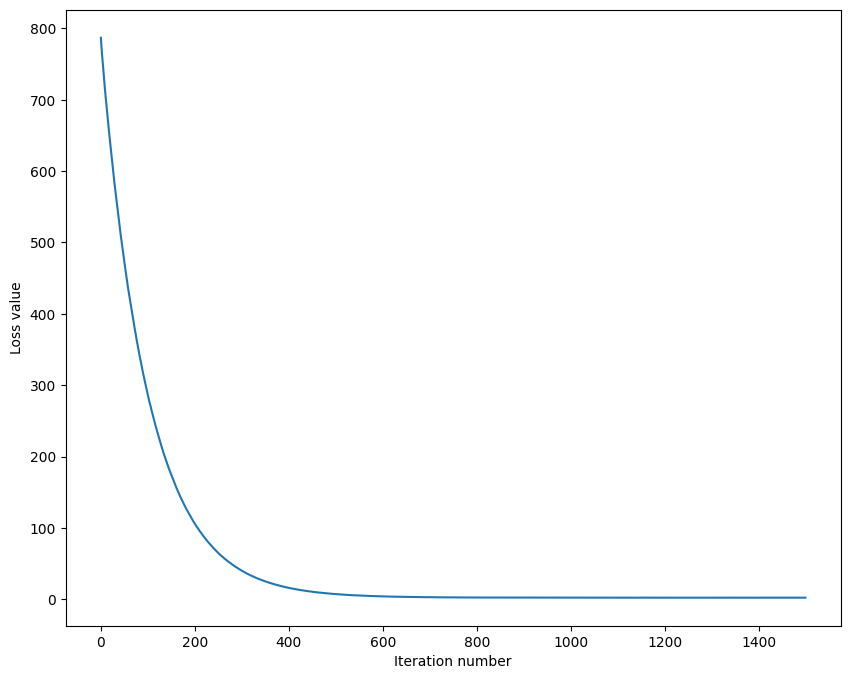

In [142]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [143]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-6, 2.5e-6]
regularization_strengths = [1e3, 1e4, 2e4, 2.5e4, 3e4, 3.5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

grid_search = [(lr, reg) for lr in learning_rates for reg in regularization_strengths]

for learning_rate, regularization_strength in grid_search:
    softmax = Softmax()
    loss_hist = softmax.train(X_train, y_train, learning_rate, regularization_strength, num_iters=1500)

    y_train_pred = softmax.predict(X_train)
    y_val_pred = softmax.predict(X_val)

    train_accuracy = np.mean(y_train_pred == y_train)
    val_accuracy = np.mean(y_val_pred == y_val)

    results[(learning_rate, regularization_strength)] = (train_accuracy, val_accuracy)

    if val_accuracy > best_val:
        best_val = val_accuracy
        best_softmax = softmax

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.162796 val accuracy: 0.170000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.268612 val accuracy: 0.266000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.253837 val accuracy: 0.255000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.262388 val accuracy: 0.277000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.263163 val accuracy: 0.272000
lr 1.000000e-07 reg 3.500000e+04 train accuracy: 0.250204 val accuracy: 0.256000
lr 2.000000e-06 reg 1.000000e+03 train accuracy: 0.153959 val accuracy: 0.127000
lr 2.000000e-06 reg 1.000000e+04 train accuracy: 0.099959 val accuracy: 0.102000
lr 2.000000e-06 reg 2.000000e+04 train accuracy: 0.100020 val accuracy: 0.105000
lr 2.000000e-06 reg 2.500000e+04 train accuracy: 0.100469 val accuracy: 0.078000
lr 2.000000e-06 reg 3.000000e+04 train accuracy: 0.099857 val accuracy: 0.107000
lr 2.000000e-06 reg 3.500000e+04 train accuracy: 0.100041 val accuracy: 0.098000
lr 2.500000e-06 reg 1.000000

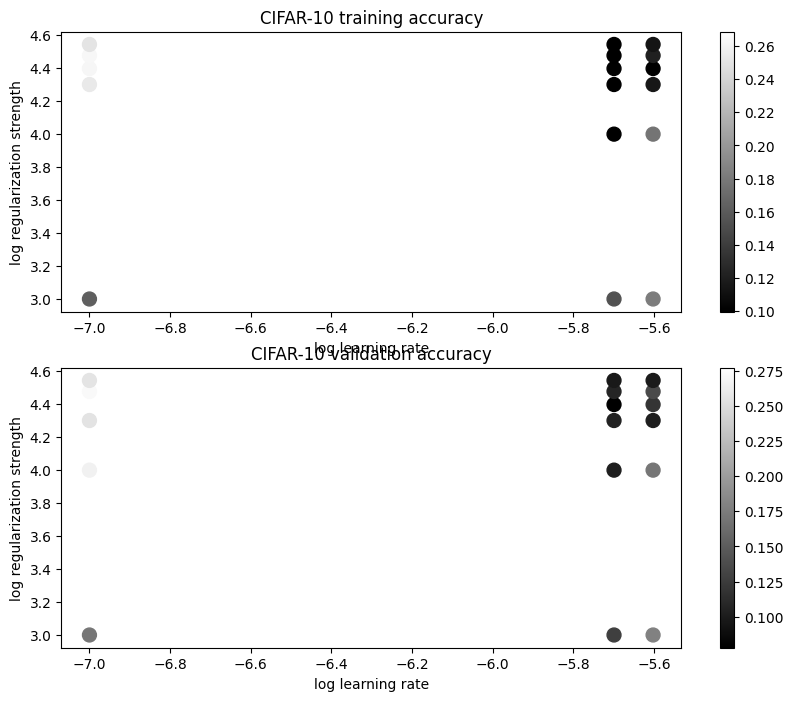

In [144]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [145]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.284000


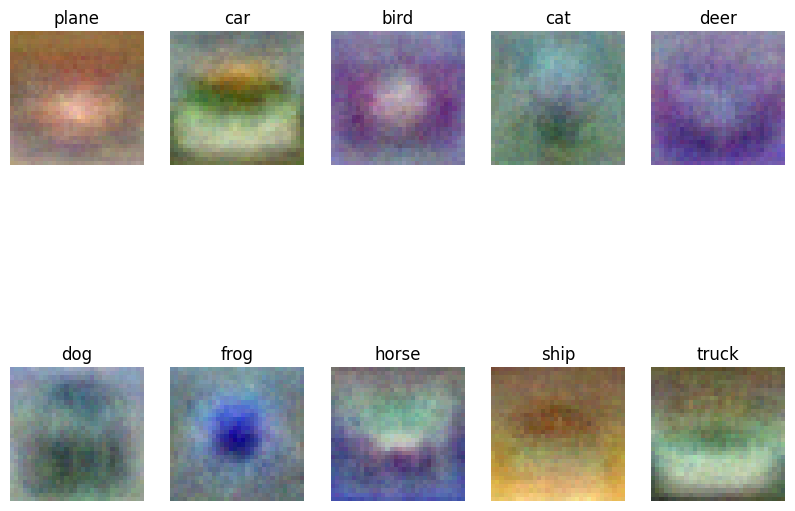

In [146]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# Submission

It should be a pdf file.

Please use the print function of your browser (Chrome, etc.) to convert this notebook to PDF.

Content is mostly borrowed from Stanford CS231n.